In [1]:
import torch

torch.set_default_dtype(torch.float32)
torch.manual_seed(91021)
torch.__version__


'2.2.1+cu121'

# 1. Make classification data

In [2]:
from sklearn.datasets import make_circles

# make 1000 samples
n_samples = 1000

# create circles
X, y = make_circles(n_samples, noise=0.03, random_state=91021)


In [3]:
print(f"First 5 X features:\n{X[:5]}")
print(f"\nFirst 5 y labels:\n{y[:5]}")


First 5 X features:
[[ 0.2483671  -0.81447779]
 [-0.82877672 -0.18907591]
 [ 0.15490295 -0.77510797]
 [-0.87037195  0.53598668]
 [-0.86404739 -0.00505865]]

First 5 y labels:
[1 1 1 0 1]


In [4]:
import pandas as pd

circles = pd.DataFrame({"X1": X[:, 0], "X2": X[:, 1], "label": y})
circles.head(10)


,X1,X2,label
0,0.248367,-0.814478,1
1,-0.828777,-0.189076,1
2,0.154903,-0.775108,1
3,-0.870372,0.535987,0
4,-0.864047,-0.005059,1
5,0.970214,-0.071646,0
6,0.306635,0.938536,0
7,-0.486692,0.660680,1
8,-0.446776,0.635964,1
9,-0.576145,-0.555555,1


In [5]:
# check different labels count
circles.label.value_counts()


label
1    500
0    500
Name: count, dtype: int64

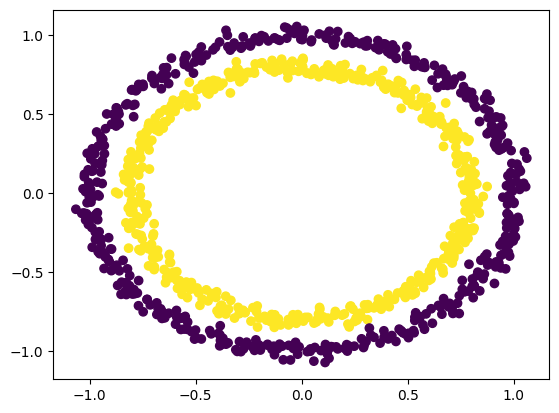

In [6]:
import matplotlib.pyplot as plt

plt.scatter(x=X[:, 0], y=X[:, 1], c=y)


## 1.1 input and output shapes

In [7]:
# check the shapes of inputs and labels
X.shape, y.shape


((1000, 2), (1000,))

In [8]:
# view the first example of features and labels
X_sample = X[0]
y_sample = y[0]
print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(
    f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}"
)


Values for one sample of X: [ 0.2483671  -0.81447779] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


## 1.2 turn data into tensors and create splits

In [ ]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]


(tensor([[ 0.2484, -0.8145],
         [-0.8288, -0.1891],
         [ 0.1549, -0.7751],
         [-0.8704,  0.5360],
         [-0.8640, -0.0051]]),
 tensor([1., 1., 1., 0., 1.]))

In [10]:
# split data into train and test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=91021
)


# 2. Building the model

In [11]:
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"


In [12]:
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # takes in 2 features (X) and produces 5 features
        self.layer_1 = nn.Linear(in_features=2, out_features=5)
        # takes in 5 features (hidden units) and produces 1 feature (y)
        self.layer_2 = nn.Linear(in_features=5, out_features=1)

    def forward(self, x):
        return self.layer_2(self.layer_1(x))


In [13]:
model_0 = CircleModelV0().to(device)
model_0


CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [14]:
# make some predictions with the model
untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")


Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[ 0.0719],
        [ 0.7431],
        [-0.0718],
        [ 0.5848],
        [ 0.3984],
        [-0.0535],
        [ 0.2071],
        [ 0.1292],
        [ 0.5821],
        [ 0.2687]], grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([0., 0., 0., 1., 1., 0., 0., 0., 1., 1.])


In [15]:
# create a loss function
loss_fn = nn.BCEWithLogitsLoss()
# create optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)


In [16]:
def accuracy_fn(y_true, y_pred):
    # compare two tensors
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc


# 3. Trainmodel

## 3.1 how it works

In [17]:
# view of the first 10 outputs of the forward pass on the test data
y_logits = model_0(X_test.to(device))[:5]
y_logits


tensor([[ 0.0719],
        [ 0.7431],
        [-0.0718],
        [ 0.5848],
        [ 0.3984]], grad_fn=<SliceBackward0>)

In [18]:
# use sigmoid on model logits
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs


tensor([[0.5180],
        [0.6777],
        [0.4820],
        [0.6422],
        [0.5983]], grad_fn=<SigmoidBackward0>)

In [19]:
# find the predicted labels
y_preds = torch.round(y_pred_probs)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))
y_preds.squeeze()


tensor([True, True, True, True, True])


tensor([1., 1., 0., 1., 1.], grad_fn=<SqueezeBackward0>)

## 3.2 building a training and testing loop

In [20]:
torch.manual_seed(91021)

# set number of epochs
epochs = 100

# allocate data on device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# build training and evaluation loop
for epoch in range(epochs):
    ### training
    model_0.train()

    # 1. forward pass
    y_logits = model_0(X_train).squeeze()
    y_preds = torch.round(torch.sigmoid(y_logits))

    # 2. calculate loss
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_preds)

    # 3. zero grad
    optimizer.zero_grad()

    # 4. loss backward
    loss.backward()

    # 5. step
    optimizer.step()

    ### testing
    model_0.eval()
    with torch.inference_mode():
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    # print out what's happening
    if epoch % 10 == 0:
        print(
            f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%"
        )


Epoch: 0 | Loss: 0.71996, Acc: 58.88% | Test Loss: 0.71418, Test Acc: 55.00%
Epoch: 10 | Loss: 0.70350, Acc: 52.00% | Test Loss: 0.70008, Test Acc: 53.00%
Epoch: 20 | Loss: 0.69872, Acc: 50.38% | Test Loss: 0.69608, Test Acc: 52.50%
Epoch: 30 | Loss: 0.69701, Acc: 49.88% | Test Loss: 0.69480, Test Acc: 52.00%
Epoch: 40 | Loss: 0.69618, Acc: 49.88% | Test Loss: 0.69431, Test Acc: 50.50%
Epoch: 50 | Loss: 0.69565, Acc: 49.62% | Test Loss: 0.69410, Test Acc: 49.50%
Epoch: 60 | Loss: 0.69525, Acc: 49.38% | Test Loss: 0.69399, Test Acc: 49.50%
Epoch: 70 | Loss: 0.69492, Acc: 49.38% | Test Loss: 0.69394, Test Acc: 49.50%
Epoch: 80 | Loss: 0.69464, Acc: 50.00% | Test Loss: 0.69392, Test Acc: 49.00%
Epoch: 90 | Loss: 0.69441, Acc: 49.75% | Test Loss: 0.69392, Test Acc: 50.00%


# 4. Make predictions

In [21]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping download")
else:
    print("Downloading helper_functions.py")
    request = requests.get(
        "https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py"
    )
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary


helper_functions.py already exists, skipping download


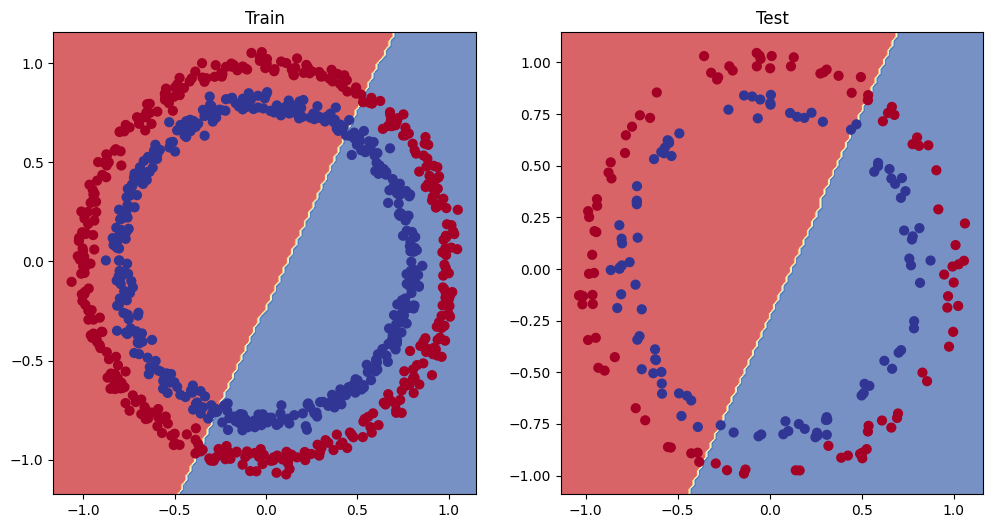

In [22]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)


### attempt improving

In [23]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)

    def forward(self, x):
        z = self.layer_1(x)
        z = self.layer_2(z)
        z = self.layer_3(z)
        return z


model_1 = CircleModelV1().to(device)
model_1


CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [24]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)


In [26]:
torch.manual_seed(91021)
epochs = 1000
for epoch in range(epochs):
    model_1.train()

    y_logits = model_1(X_train).squeeze()
    y_preds = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_preds)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_1.eval()
    with torch.inference_mode():
        test_logits = model_1(X_test).squeeze()
        test_preds = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_preds)

    if epoch % 100 == 0:
        print(
            f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%"
        )


Epoch: 0 | Loss: 0.70811, Acc: 49.88% | Test Loss: 0.70328, Test Acc: 50.50%
Epoch: 100 | Loss: 0.69291, Acc: 50.75% | Test Loss: 0.69456, Test Acc: 49.50%
Epoch: 200 | Loss: 0.69288, Acc: 51.62% | Test Loss: 0.69511, Test Acc: 46.50%
Epoch: 300 | Loss: 0.69288, Acc: 51.50% | Test Loss: 0.69521, Test Acc: 46.00%
Epoch: 400 | Loss: 0.69288, Acc: 51.62% | Test Loss: 0.69524, Test Acc: 46.00%
Epoch: 500 | Loss: 0.69288, Acc: 51.62% | Test Loss: 0.69525, Test Acc: 46.50%
Epoch: 600 | Loss: 0.69288, Acc: 51.62% | Test Loss: 0.69526, Test Acc: 46.50%
Epoch: 700 | Loss: 0.69288, Acc: 51.62% | Test Loss: 0.69526, Test Acc: 46.50%
Epoch: 800 | Loss: 0.69288, Acc: 51.62% | Test Loss: 0.69526, Test Acc: 46.50%
Epoch: 900 | Loss: 0.69288, Acc: 51.62% | Test Loss: 0.69526, Test Acc: 46.50%


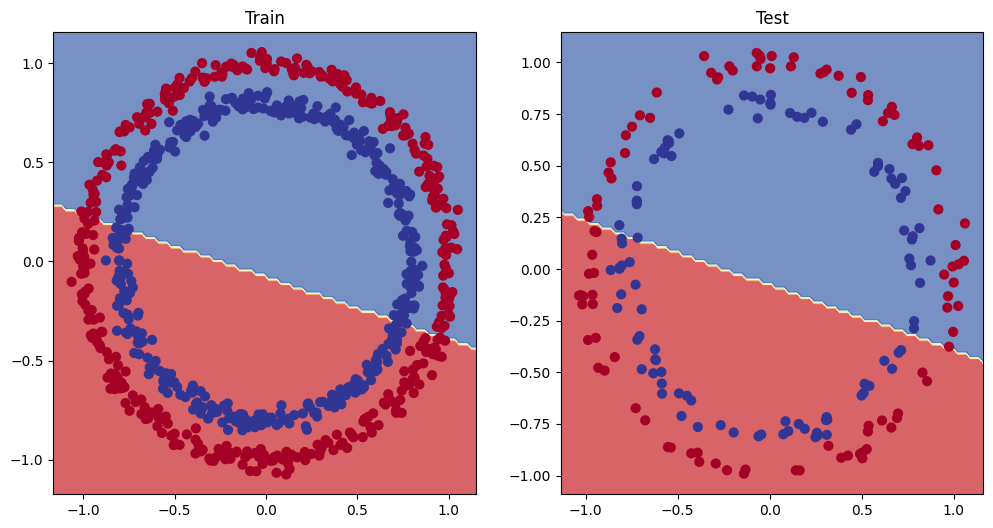

In [27]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)
